In [1]:
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(7,4), 'figure.dpi':80})
import warnings 
warnings.filterwarnings('ignore')

In [7]:
df=pd.read_csv('India covid-19.csv')
df.head()

,Date,Total Confirmed,Total Recovered,Total Deceased
0,1/30/2020,1,0,0
1,1/31/2020,1,0,0
2,2/1/2020,1,0,0
3,2/2/2020,2,0,0
4,2/3/2020,3,0,0


<AxesSubplot:xlabel='Date'>

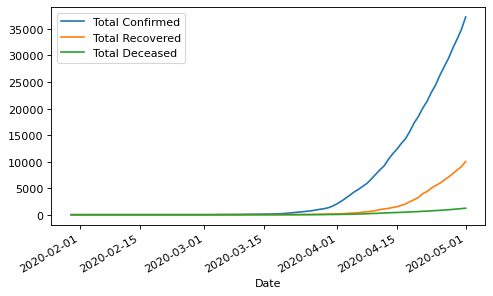

In [8]:
df.set_index('Date',inplace=True)
df.index=pd.to_datetime(df.index)
#drop null values
df.dropna(inplace=True)
df.plot()

In [9]:
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

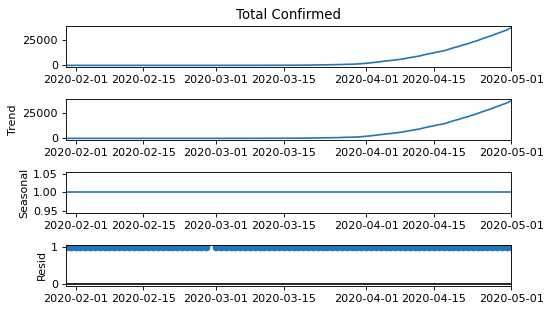

In [11]:
result=seasonal_decompose(df['Total Confirmed'],  model='multiplicable', period=1)
result.plot()
plt.show()

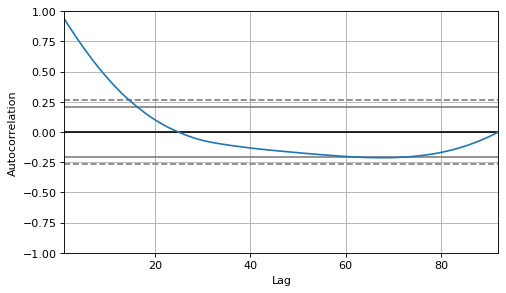

In [12]:
autocorrelation_plot(df['Total Confirmed'])
plt.show()

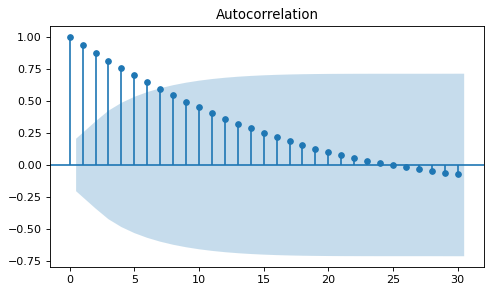

In [14]:
plot_acf(df['Total Confirmed'], lags=30)
plt.show()

In [15]:
result=adfuller(df['Total Confirmed'])
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
for value,label in zip(result,labels):
    print(label+' : '+str(value) )

if result[1] <= 0.05:
    print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
    print("weak evidence against null hypothesis,indicating it is non-stationary ")

ADF Test Statistic : -1.9866748601992539
p-value : 0.29244609756426443
#Lags Used : 12
Number of Observations : 79
weak evidence against null hypothesis,indicating it is non-stationary 


In [19]:
train = df[:int(0.90*(len(df)))]
valid = df[int(0.90*(len(df))):]

<AxesSubplot:xlabel='Date'>

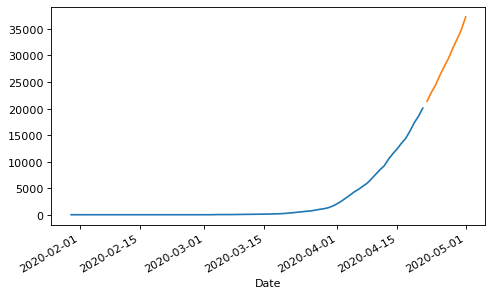

In [20]:
#plotting the data
train['Total Confirmed'].plot()
valid['Total Confirmed'].plot()

In [21]:
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
from pmdarima.arima import AutoARIMA

In [23]:
#building the model
arima_model = pm.auto_arima(train['Total Confirmed'])
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   82
Model:               SARIMAX(1, 2, 2)   Log Likelihood                -476.396
Date:                Thu, 24 Jun 2021   AIC                            960.792
Time:                        08:59:26   BIC                            970.320
Sample:                             0   HQIC                           964.612
                                 - 82                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9917      0.018     56.013      0.000       0.957       1.026
ma.L1         -1.6969      0.047    -36.295      0.000      -1.789      -1.605
ma.L2          0.7552      0.047     16.061      0.000       0.663       0.847
sigma2      8402.0293    899.426      9.342      0.000    6639.187    1.02e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.66   Jarque-Bera (JB):                76.30
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):          326436.57   Skew:                             1.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
forecasts = arima_model.predict(n_periods=valid.shape[0])
valid['forecasted infection number'] = forecasts
valid.head()

,Total Confirmed,Total Recovered,Total Deceased,forecasts infection rate,forecasted infection number
Date,,,,,
2020-04-22,21373,4370,682,21580.082914,21580.082914
2020-04-23,23040,5012,722,23143.817732,23143.817732
2020-04-24,24448,5496,781,24771.668621,24771.668621
2020-04-25,26283,5938,825,26463.104184,26463.104184
2020-04-26,27890,6523,881,28217.597433,28217.597433


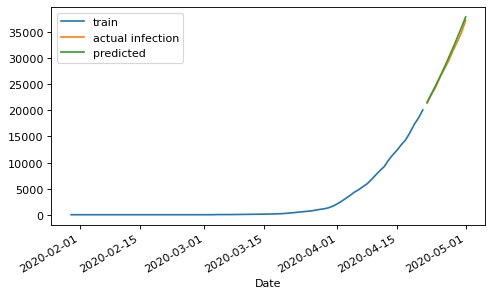

In [27]:
train["Total Confirmed"].plot()
valid["Total Confirmed"].plot()
valid["forecasted infection number"].plot()
labels = ['train', 'actual infection', 'predicted']
plt.legend(labels)

In [29]:
MAE = mean_absolute_error(valid["Total Confirmed"], valid["forecasted infection number"])
RMSE = math.sqrt(mean_squared_error(valid["Total Confirmed"], valid["forecasted infection number"]))

print("Mean Absolute Error: {:.3f}".format(MAE))
print("Root Mean Squared Error: {:.3f}".format(RMSE))

Mean Absolute Error: 471.233
Root Mean Squared Error: 545.560
